In [1]:
import torch
import torchvision.transforms as transforms

import cv2
import os
import numpy as np

import matplotlib.pyplot as plt

from models.vgg19 import Vgg19
from utils.load_image import load_style_image,load_source_image
from utils.load_model import load_vgg19


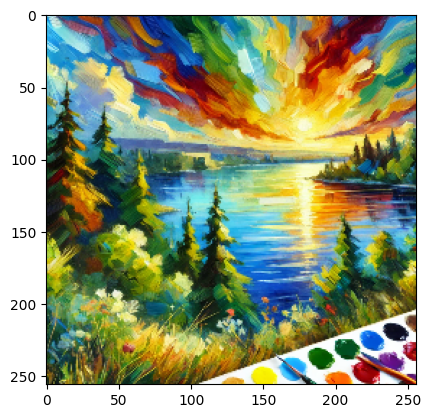

In [10]:
style_PATH='./style-image'
resource_PATH='./input_image'
select_style_image=1 #max 5
image_shape=(256,256)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')



style_img=load_style_image(style_PATH,select_style_image,image_shape)
transform=transforms.Compose([
    transforms.ToTensor()
])

style_img=transform(style_img)
plt.imshow(style_img.permute(1,2,0))



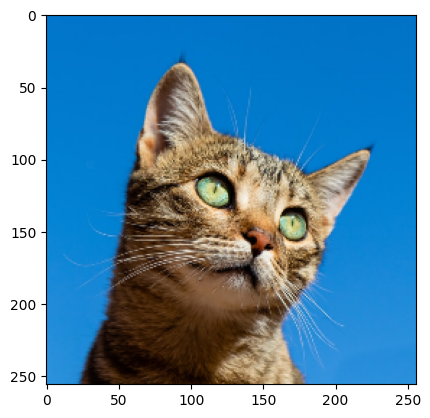

In [11]:

resource_image=load_source_image(resource_PATH,image_shape)
resource_image=transform(resource_image)
plt.imshow(resource_image.permute(1,2,0))


# model 정의

In [12]:
vgg19, content_feature_maps_index_name, style_feature_maps_indices_names = load_vgg19()
vgg19.to(device)
vgg19.eval()

Vgg19(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (slice4): Sequential(
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): R

In [13]:
init_resource_image=resource_image.clone().detach().to(device).unsqueeze(0).requires_grad_(True)
content_img_set_of_feature_maps=vgg19(init_resource_image)
style_img_set_of_feature_maps = vgg19(style_img.to(device).unsqueeze(0))
target_content_representation=content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(0)




In [14]:
def gram_matrix(x):
    (b,ch,h,w)=x.size()
    features=x.view(b,ch,h*w)
    #print(features.shape)
    features_t=features.transpose(1,2) # (b,ch,h*w) -> (b,h*w,ch)
    gram=features.bmm(features_t) # (b,ch,h*w) * (b,h*w,ch) -> (b,ch,ch) #배치행렬곱    
    gram=gram/(ch*h*w)
    return gram

def show_image(image):

    image = image.detach().cpu().numpy()[0]  # Tensor를 NumPy로 변환
    #image = (image + 1) * 127.5  # -1 ~ 1 -> 0 ~ 255 스케일로 변환
    image = np.clip(image*255, 0, 255).astype(np.uint8)  # 값 범위 제한 및 uint8로 변환

    # 이미지 시각화
    plt.imshow(image.transpose(1, 2, 0))  # (C, H, W) -> (H, W, C)로 변환
    plt.axis('off')  # 축 제거
    plt.show()


In [15]:
target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
target_representations = [target_content_representation, target_style_representation]

EPOCH: 100 |  TOTAL_LOSS: 2702.6083984 | style_loss: 0.0270261 | COUNT: 0 | LR: 0.0300000


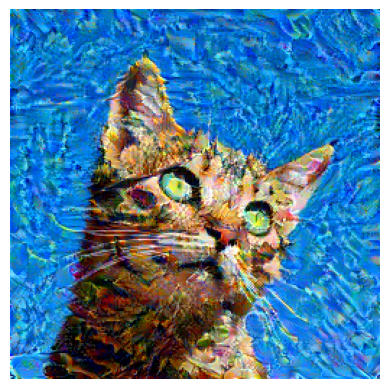

In [16]:
init_resource_image=resource_image.clone().detach().to(device).unsqueeze(0).requires_grad_(True)
epochs=100
optimizer=torch.optim.Adam([init_resource_image],lr=0.03)
cnt=0


best_loss=1e+9
for epoch in range(epochs):
    optimizer.zero_grad()
    target_style_representation = target_representations[1]
    
    current_set_of_feature_maps=vgg19(init_resource_image)
    current_content_representation=current_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(0)

    
    
    style_loss=0.0
    current_style_representation = [gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
    for gram_gt, gram_hat in zip(target_style_representation, current_style_representation): # 5개
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
        
    style_loss /= len(target_style_representation) # 스타일 loss 계산
    total_loss =  (style_loss*100000)#+(tv_loss*1.0)

    total_loss.backward()
    optimizer.step()
    current_lr=optimizer.param_groups[0]['lr']
    if (epoch+1)%100==0:
        print(f"EPOCH: {epoch+1} |  TOTAL_LOSS: {total_loss:.7f} | style_loss: {style_loss:.7f} | COUNT: {cnt} | LR: {current_lr:.7f}")
        show_image(init_resource_image)

    
    if best_loss > total_loss:
        best_loss=total_loss
        cnt=0
    else:
        cnt=1
    if cnt==10:
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7201027..1.624256].


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

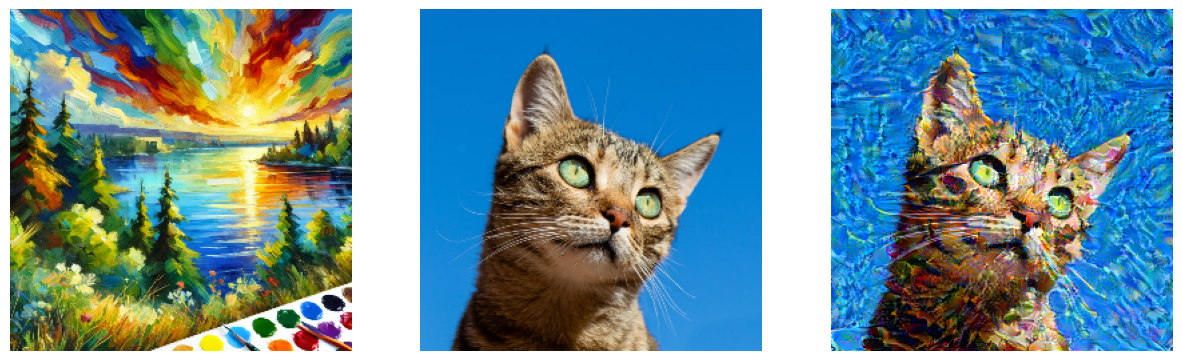

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(style_img.cpu().detach().permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(resource_image.cpu().detach().permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(init_resource_image[0].cpu().detach().permute(1,2,0))
plt.axis('off')
